In [14]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [15]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [16]:
# Save the input and target variables

# print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [17]:
# targets

In [18]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) / targets.std(axis=0)

# targets

In [19]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [20]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    
    return model

model = get_model()

In [21]:
# Print the model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [22]:
# Compile the model

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [23]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data,train_targets,epochs=100,
          validation_split=0.15, batch_size=64,verbose=False)


In [24]:
# Evaluate the model on the test set
model.evaluate(test_data,test_targets, verbose=2)


45/1 - 0s - loss: 1.6363 - mae: 0.7705


[1.169627857208252, 0.7705251]

#### Plot the learning curves

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

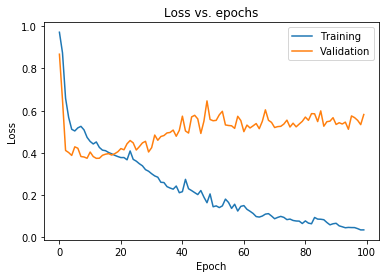

In [26]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [27]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [28]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer= regularizers.l2(wd), 
              activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [29]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [30]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [31]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15, batch_size=64, verbose=False)

In [32]:
# Evaluate the model on the test set

model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 0.9255 - mae: 0.6815


[0.7494162718454996, 0.68149936]

#### Plot the learning curves

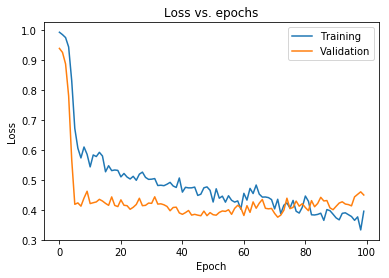

In [33]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [34]:
# Write a custom callback

from  tensorflow.keras.callbacks import Callback

class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting prediction....")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}")
        
    def on_predict_end(self,epoch, logs=None):
        print(f"Finished Prediction")

In [35]:
# Write a custom callback

from  tensorflow.keras.callbacks import Callback

class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing....")
        
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")
        
    def on_test_end(self,epoch, logs=None):
        print(f"Finished testing")

In [36]:
# Write a custom callback

from  tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training....")
        
    def on_epoch_begin(self,epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self,epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self,epoch, logs=None):
        print(f"Finished training")

In [37]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [38]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [39]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128,
         verbose=False, callbacks=[TrainingCallback()])

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training


In [40]:
# Evaluate the model

model.evaluate(test_data,test_targets, verbose=2, callbacks=[TestingCallback()])

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
45/1 - 0s - loss: 1.2411
Finished testing


1.122840592596266

In [41]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting prediction....
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished Prediction


array([[ 0.04076002],
       [-0.04213377],
       [ 0.08382418],
       [ 0.01733424],
       [ 0.06527966],
       [ 0.01449485],
       [-0.08245024],
       [-0.05374664],
       [ 0.07222327],
       [-0.07528   ],
       [ 0.05706395],
       [ 0.11248568],
       [ 0.08451182],
       [ 0.03065781],
       [ 0.01321298],
       [-0.05101206],
       [-0.02257289],
       [-0.06691979],
       [-0.07344104],
       [-0.07936655],
       [ 0.05164295],
       [ 0.09195953],
       [-0.03821776],
       [-0.07773511],
       [-0.07534587],
       [-0.0389628 ],
       [ 0.12092414],
       [-0.05797993],
       [-0.02730934],
       [-0.00401009],
       [-0.07295521],
       [ 0.04060319],
       [-0.07663991],
       [-0.03478005],
       [ 0.07408053],
       [ 0.09034568],
       [ 0.0765423 ],
       [-0.02613023],
       [ 0.04242121],
       [ 0.03143873],
       [ 0.03781271],
       [-0.06147049],
       [-0.01255249],
       [-0.00754647],
       [ 0.05940992]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [54]:
# Re-train the unregularised model

unregularized_model = get_model()
unregularized_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularized_model.fit(train_data,train_targets,epochs=100,
                                   validation_split=0.15,batch_size=64,
                                   verbose=False,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [55]:
# Evaluate the model on the test set

unregularized_model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 0.7235


0.6353613032235039

In [56]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(train_data,train_targets,epochs=100,
                                   validation_split=0.15,batch_size=64,
                                   verbose=False,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [57]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 0.7574


0.645752481619517

#### Plot the learning curves

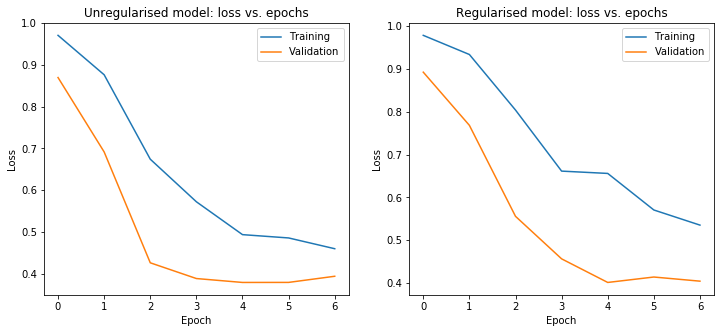

In [58]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()